In [226]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import olympus
from olympus.objects import(
        ParameterVector,
        ParameterContinuous,
        ParameterDiscrete,
        ParameterCategorical,
)
from olympus.evaluators import Evaluator
from olympus.planners import Planner
from olympus.campaigns import Campaign, ParameterSpace
from olympus.datasets import Dataset
from olympus.surfaces import Surface
from olympus.scalarizers import Scalarizer, get_scalarizers_list

In [159]:
get_scalarizers_list()

['Chimera', 'ConstrainedAsf', 'WeightedSum']

## test multiobjective optimization

In [160]:
surface_moo = Surface(kind='MultFonseca')

campaign = Campaign()
campaign.set_param_space(surface_moo.param_space)
campaign.set_value_space(surface_moo.value_space)

print(campaign.is_moo)

True


[WARNING] Surface MultFonseca is only defined with 2 objectives: setting `value_dim`=2


In [161]:
# initialize chimera asf
tolerances = [0.4, 0.2]
absolutes = [False, False]
goals = ['min', 'min']
scalarizer = Scalarizer(
    kind='Chimera',
    value_space=surface_moo.value_space,
    tolerances=tolerances,
    absolutes=absolutes,
    goals=goals,
)

print(scalarizer)


--> absolutes:   [False, False]
--> goals:       ['min', 'min']
--> tolerances:  [0.4, 0.2]
--> value_space: Continuous (name='value_0', low=0.0, high=1.0, is_periodic=False)
Continuous (name='value_1', low=0.0, high=1.0, is_periodic=False)


In [162]:
# make some mock observations
params = [
    ParameterVector().from_dict({'param_0': 0.01, 'param_1': 0.99}),
    ParameterVector().from_dict({'param_0': 0.99, 'param_1': 0.01}),
    ParameterVector().from_dict({'param_0': 0.49, 'param_1': 0.51}),
]


In [163]:
values = []
for param in params:
    values.extend(
        surface_moo.run(param.to_array(), return_paramvector=True)
    )
values

[ParamVector(value_0 = 0.432200228643724, value_1 = 0.9664397706162793),
 ParamVector(value_0 = 0.432200228643724, value_1 = 0.9664397706162793),
 ParamVector(value_0 = 0.08239332394014476, value_1 = 0.9457641723612471)]

In [164]:
# add the first observation to the campaign

campaign.add_and_scalarize(
    params[0], values[0], scalarizer
)

In [165]:
campaign.observations.get_values()

array([[0.43220023, 0.96643977]])

In [166]:
campaign.scalarized_observations.get_values()

array([0.])

In [167]:
campaign.add_and_scalarize(
    params[1], values[1], scalarizer
)

In [168]:
campaign.add_and_scalarize(
    params[2], values[2], scalarizer
)

In [169]:
campaign.observations.get_values()

array([[0.43220023, 0.96643977],
       [0.43220023, 0.96643977],
       [0.08239332, 0.94576417]])

In [170]:
campaign.scalarized_observations.get_values()

array([1., 1., 0.])

## Make sure single objective optimization doesnt break

In [171]:
surface_soo = Surface(kind='Dejong')

campaign = Campaign()
campaign.set_param_space(surface_soo.param_space)
campaign.set_value_space(surface_soo.value_space)

In [172]:
# make some mock observations
params = [
    ParameterVector().from_dict({'param_0': 0.01, 'param_1': 0.99}),
    ParameterVector().from_dict({'param_0': 0.99, 'param_1': 0.01}),
    ParameterVector().from_dict({'param_0': 0.49, 'param_1': 0.51}),
]


In [173]:
values = []
for param in params:
    values.extend(
        surface_soo.run(param.to_array(), return_paramvector=True)
    )
values

[ParamVector(value_0 = 4.427188724235731),
 ParamVector(value_0 = 4.427188724235731),
 ParamVector(value_0 = 0.6324555320336748)]

In [174]:
# add the first observation to the campaign

campaign.add_observation(params[0], values[0])

In [175]:
campaign.observations.get_values()
campaign.scalarized_observations.get_values()

[]

In [176]:
campaign.add_observation(params[1], values[1])

In [177]:
campaign.observations.get_values()
#campaign.scalarized_observations.get_values()

array([[4.42718872],
       [4.42718872]])

In [178]:
campaign.add_observation(params[2], values[2])

In [179]:
campaign.observations.get_values()
#campaign.scalarized_observations.get_values()

array([[4.42718872],
       [4.42718872],
       [0.63245553]])

## Test closed loop optimization with high level Evaluator interface within Olympus

In [228]:
surface_moo = Surface(kind='MultFonseca')

campaign = Campaign()
campaign.set_param_space(surface_moo.param_space)
campaign.set_value_space(surface_moo.value_space)

print('is_moo : ', campaign.is_moo)

is_moo :  True


[WARNING] Surface MultFonseca is only defined with 2 objectives: setting `value_dim`=2


In [229]:
# initialize planner 
planner = Planner(kind='RandomSearch', goal='minimize')

In [230]:
# initialize asf

#---------
# Chimera
#---------

# tolerances = [0.4, 0.2]
# absolutes = [False, False]
# goals = ['min', 'min']
# scalarizer = Scalarizer(
#     kind='Chimera',
#     value_space=surface_moo.value_space,
#     tolerances=tolerances,
#     absolutes=absolutes,
#     goals=goals,
# )

#-------------
# WeightedSum
#-------------

weights = [0.5, 0.5]
goals = ['min', 'min']

scalarizer = Scalarizer(
    kind='WeightedSum', 
    value_space=surface_moo.value_space,
    weights=weights,
    goals=goals
)


In [231]:
evaluator = Evaluator(
    planner=planner,
    emulator=surface_moo,
    campaign=campaign,
    scalarizer=scalarizer,
    database=None
)

In [232]:
evaluator

In [233]:
evaluator.optimize(num_iter=5)

In [234]:
campaign

<Campaign (dataset=n/a, model=n/a, planner=RandomSearch, num_iter=5)>

In [235]:
campaign.observations.get_params()

array([[0.59567145, 0.18897484],
       [0.83325796, 0.01139659],
       [0.32791269, 0.00397691],
       [0.77236943, 0.31600847],
       [0.27137353, 0.15102542]])

In [236]:
campaign.observations.get_values()

array([[0.24487996, 0.91793087],
       [0.39342493, 0.94436655],
       [0.47174691, 0.79338649],
       [0.14548148, 0.96066398],
       [0.39291711, 0.816183  ]])

In [237]:
campaign.scalarized_observations.get_values()

array([0.24462052, 1.        , 0.68634003, 0.        , 0.44444819])

In [238]:
best_values = campaign.best_values

In [239]:
best_values.shape
best_values

array([[0.24487996, 0.91793087],
       [0.24487996, 0.91793087],
       [0.24487996, 0.91793087],
       [0.14548148, 0.96066398],
       [0.14548148, 0.96066398]])

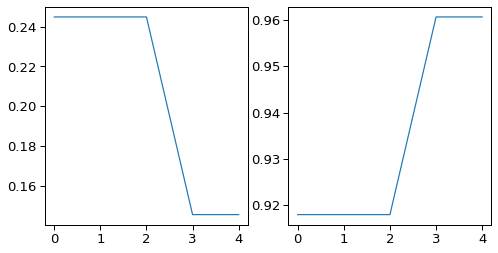

In [241]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].plot(best_values[:, 0])
axes[1].plot(best_values[:, 1])